# Building LLM Agents and Workflows with LangGraph

## Introduction to LLMs and LangGraph

Large Language Models (LLMs) have become central to natural language processing, excelling at understanding and generating human-like text. Their broad utility spans content creation, translation, code generation, and tackling complex problems.

LLMs often need to go beyond simple text generation to accomplish more complex tasks, requiring interaction with external tools or executing sequences of operations. This is where **LLM applications** come in. **LangGraph** is a library built on top of LangChain that provides a powerful way to build **stateful, multi-actor applications** with LLMs. It models the steps an application takes as **nodes** in a graph and the flow of execution between these steps as **edges**.

LangGraph supports two primary modes for building these applications: **Agent mode** and **Workflow mode**.

*   **Agent Mode:** Designed for building **LLM agents**, where the LLM acts as the central reasoning engine, dynamically deciding actions and often using tools in iterative processes.
*   **Workflow Mode:** More general, allowing you to define **arbitrary, predefined sequences of steps** where the execution flow is explicitly defined by the graph's edges, which may or may not include LLMs.

Using LangGraph, whether in Agent or Workflow mode, offers several advantages:

*   **Managing Complex Interactions:** The graph structure provides a clear way to define and manage intricate sequences of operations, decision points, and loops.
*   **Handling Tools:** It offers a structured mechanism for applications to utilize external tools and process their outputs.
*   **Enabling Stateful Execution:** LangGraph maintains a shared state that nodes can read and write to, allowing information to persist and evolve throughout the application's execution.

## Goal of this Tutorial

The goal of this tutorial is to guide you through the process of building LLM applications using both Agent and Workflow modes in LangGraph. We will start with building **LLM agents** and then explore **workflow building**.

## Setting up the environment

Installing the necessary libraries (LangChain, LangGraph, etc.).


Before we begin building our LLM agent, we need to install the necessary libraries. We will be using `langchain` as our core framework for working with LLMs and `langgraph` for orchestrating the agent's workflow.

You can install these libraries using pip, the Python package installer, by running the following commands in your terminal or directly in a code cell within this notebook:
bash
pip install langchain langgraph

In [2]:
# If you're on Colab, run this once.
!pip -q install --upgrade langgraph langchain-core langchain-openai pydantic graphviz langchain_groq
# Graphviz system package for diagrams (Colab usually has it, but just in case):
!apt-get -qq install -y graphviz > /dev/null
!apt install libgraphviz-dev
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.4/501.4 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.6/463.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pydantic<=2.12.3,>=2.0, but you have pydantic 2.12.5 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libatk1.0-0 liba

You can register and create free API keys at https://console.groq.com/keys


In [3]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")
# ALTERNATIVE loading if you want to use OPENAI_API_KEY
# if "OPENAI_API_KEY" not in os.environ:
#     os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OPENAI API key: ")
#     os.environ["OPENAI_API_BASE"] = getpass.getpass("Enter your OPENAI API base URL: ")
#     MODEL_NAME = os.environ.get("OPENAI_MODEL_NAME", "gpt-4.1-mini")

Enter your Groq API key: ··········


## Basic concepts

## Agent Mode vs. Workflow Mode

LangGraph offers two primary modes for structuring your LLM applications: **Agent mode** and **Workflow mode**. While both use the graph structure of nodes and edges, they differ fundamentally in how the flow of execution is determined. Understanding this distinction is crucial for choosing the right approach for your specific application.

### Agent Mode

**Agent mode** is specifically designed for building **LLM agents**. In this mode, the **LLM acts as the central controller and decision-maker**. The flow of execution through the graph is not strictly predefined; instead, the LLM dynamically decides the next step based on the current state, the user's input, and the available tools.

**Key Characteristics:**

*   **LLM as Controller:** The LLM is responsible for determining the sequence of actions. It receives the current state and decides whether to call a tool, generate a response, or perform another action.
*   **Dynamic Execution Flow:** The path through the graph is not fixed. Conditional edges are heavily used, with the condition often evaluated based on the LLM's output (e.g., did the LLM request a tool call?).
*   **Iterative Reasoning:** Agents can engage in multi-step reasoning processes, potentially looping through nodes (e.g., LLM -> Tool -> LLM -> Tool...) until a task is completed or a final answer is generated.
*   **Tool-Use Centric:** Agent mode is highly suited for applications where the LLM needs to interact with various external tools to gather information or perform actions.

**Use Cases:**

*   Building conversational agents that can answer questions, perform tasks using tools (like searching or calculating), and maintain conversation history.
*   Creating agents that can break down complex problems into smaller steps and iteratively work towards a solution.
*   Developing autonomous agents that can operate in dynamic environments and make decisions on the fly.

**Conceptual Example:** Imagine a personal assistant agent. When you ask it to "Find the weather in London and then book a table at a restaurant nearby," the agent (LLM) would first decide to use a weather tool, then process the result, then decide to use a restaurant search tool, process that result, and finally use a booking tool. The sequence of tool calls is determined by the LLM's interpretation of your request and the results it gets back.

### Workflow Mode

**Workflow mode**, on the other hand, is more general and allows you to define **arbitrary, predefined sequences of steps**. While you can include LLM calls within a workflow, the **flow of execution is explicitly defined by the graph's edges and conditional logic** that you program, rather than being solely driven by the LLM's dynamic decisions.

**Key Characteristics:**

*   **Programmatic Control Flow:** The sequence of node execution is determined by the explicitly defined edges and conditional logic written by the developer.
*   **Fixed Execution Path (mostly):** While conditional edges can introduce branching, the possible paths are defined in advance by the graph structure. The LLM, if used, is a component within a step, not the orchestrator of the steps.
*   **Task-Specific Orchestration:** Workflow mode is ideal for orchestrating a fixed sequence of operations, which might include data processing, API calls, LLM calls, human review steps, etc.
*   **Predictable Execution:** The execution flow is more predictable as it follows the defined graph structure.

**Use Cases:**

*   Building data processing pipelines that involve LLM steps (e.g., summarize text after fetching it, classify text after cleaning).
*   Creating multi-step content generation processes (e.g., outline generation -> draft writing -> editing with LLM -> formatting).
*   Implementing approval workflows where different nodes represent different stages (e.g., initial draft -> LLM review -> human approval).

**Conceptual Example:** Consider a document processing workflow. The document first goes to a cleaning node, then to a node that extracts key information using an LLM, then to a node that stores the information in a database, and finally to a notification node. The document *always* follows this sequence unless a predefined condition (like an error in cleaning) routes it to an error handling node. The LLM is used in one specific step, but it doesn't decide the overall flow.

### Key Differences

| Feature           | Agent Mode                                  | Workflow Mode                                    |
| :---------------- | :------------------------------------------ | :----------------------------------------------- |
| **Controller**    | LLM dynamically decides the next step       | Developer defines the flow via edges and logic   |
| **Execution Flow**| Dynamic, potentially iterative loops        | Predefined structure with conditional branching  |
| **Primary Use**   | Building intelligent, decision-making agents | Orchestrating fixed sequences of operations      |
| **Complexity**    | Often involves more complex state and logic for decision making | Focus on structuring sequential or branched tasks |

Choosing between Agent and Workflow mode depends on whether you want the LLM to be the brain orchestrating the entire process (Agent mode) or if you want to define a fixed process flow that might include LLM steps as components (Workflow mode). Many complex applications might even combine aspects of both modes within different parts of a larger system.

## Building Agents with LangGraph (Agent Mode)

In **Agent mode**, LangGraph is used to build applications where a Language Model (LLM) acts as the central reasoning engine. The LLM is responsible for deciding the next course of action based on the current state of the conversation or task. This allows for dynamic and flexible execution flows, enabling the agent to respond to changing circumstances, use tools as needed, and engage in iterative problem-solving. The LLM essentially acts as the **controller** of the graph, directing the flow based on its understanding and reasoning.

The graph in Agent mode typically includes:

*   **An 'agent' node:** This node houses the logic for interacting with the LLM. The LLM processes the current state (like the conversation history), makes a decision (e.g., generate a response, call a tool), and updates the state with its output.
*   **Tool nodes:** If the agent can use external tools, there will be nodes dedicated to executing these tools.
*   **A conditional edge:** This crucial part of the graph routes the execution flow based on the LLM's decision. For example, it might check if the LLM's output indicates a tool call is needed or if the task is complete.
*   **Edges for iteration:** Often, there are edges that loop back to the 'agent' node after a tool call or other action, allowing the LLM to process the results and decide the next step.

Let's build a simple agent example to illustrate these concepts.


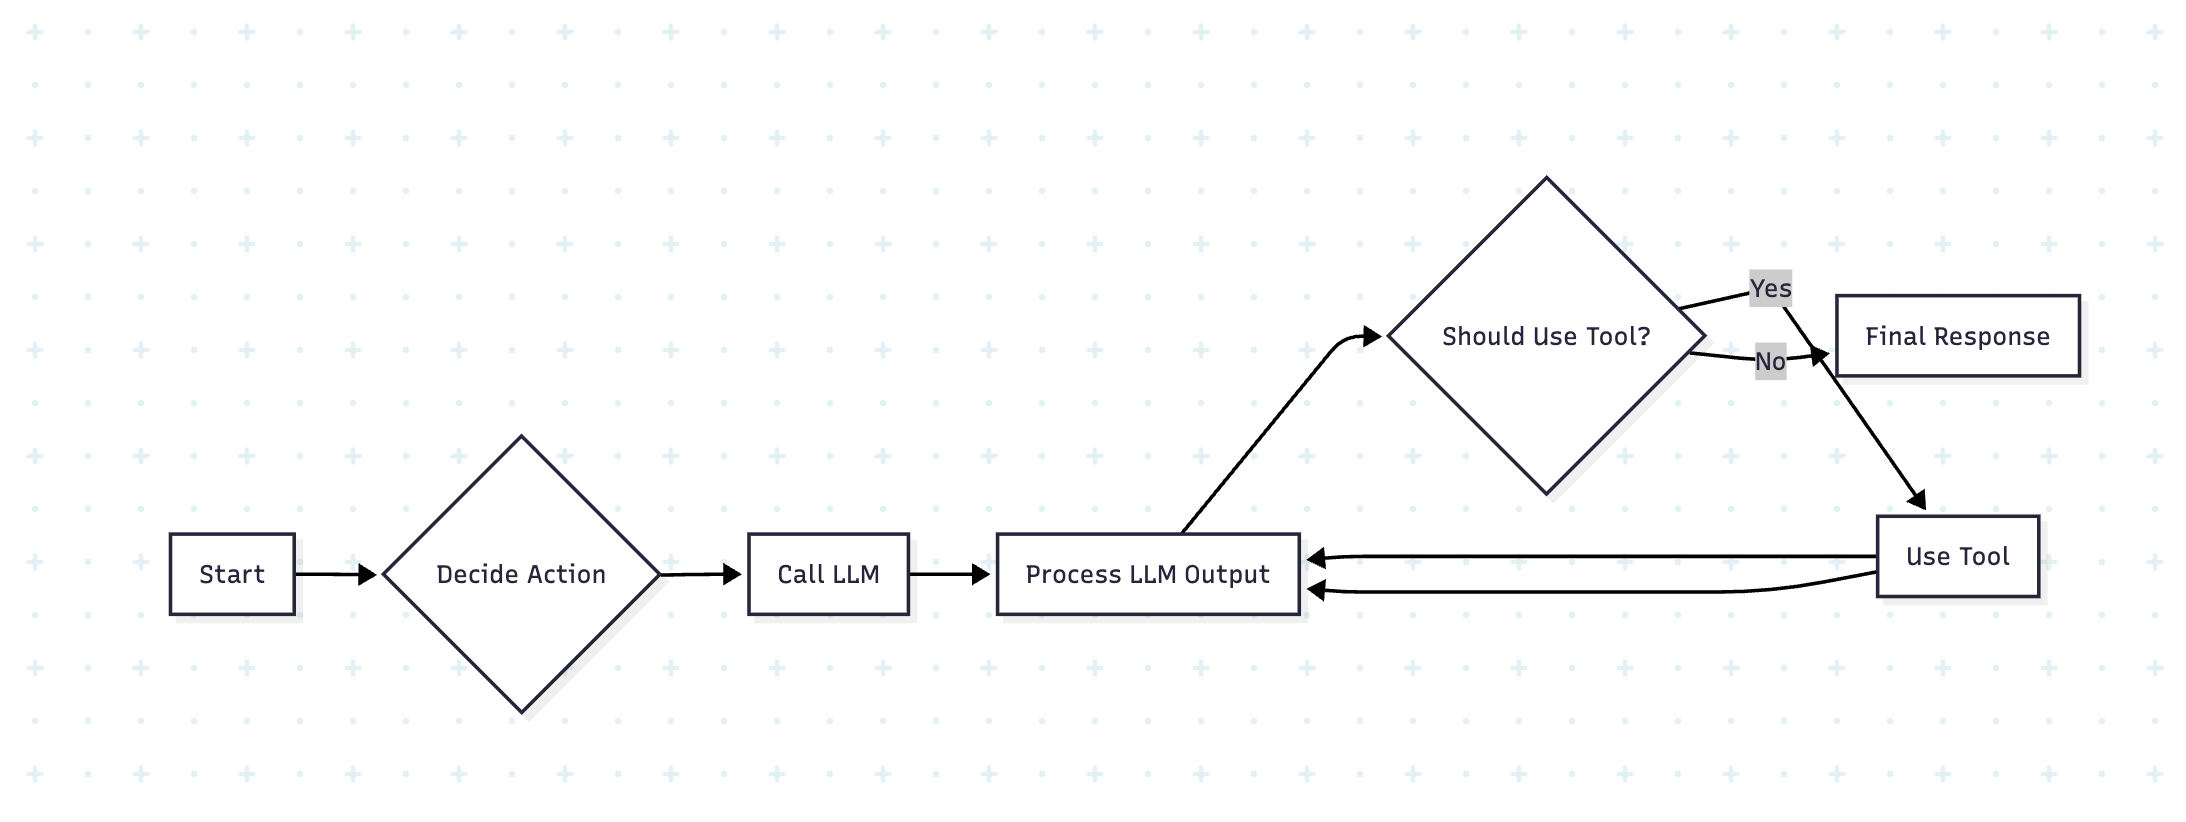
In this diagram:

*   **Nodes** are represented by the boxes (e.g., "Start", "Decide Action", "Call LLM").
*   **Edges** are the arrows connecting the nodes, showing the flow of execution.
*   **Conditional Edges** are shown branching from "Decide Action" and "Should Use Tool?", leading to different subsequent nodes based on a condition.

This simple example demonstrates how nodes and edges combine to create a flow that can involve sequential steps, decision points, and even loops (like the one from "Use Tool" back to "Process LLM Output"). LangGraph provides the framework to define and execute these graphs programmatically.

### Building a simple agent

Here we try through building a basic agent with tool(s).


In [4]:
# First, we define the llm client we will use
# This will be later reused through the lab
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

# llm = ChatOpenAI(
#     model="gpt-4o-mini",
#     temperature=0.5,
#     # LangChain's ChatOpenAI reads key & base from env: OPENAI_API_KEY / OPENAI_API_BASE
#     api_key=os.getenv("OPENAI_API_KEY"),
#     base_url=os.getenv("OPENAI_API_BASE")
# )
llm = ChatGroq(
    model="openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    # other params...
)

# Quick sanity check
resp = llm.invoke("In one sentence, what is LangGraph?")
print(resp.content)

LangGraph is a framework that lets developers build and orchestrate language‑model applications as modular, graph‑based workflows, enabling reusable nodes, state management, and dynamic routing of prompts and responses.


In [5]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    '''structured output for composing a search query (not a tool)'''

    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("Help me generate a search engine query for: How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'fc_e3d4597e-0bd8-42ed-9440-2e10e5c33c19',
  'type': 'tool_call'}]

Great! Now you have a running agent with access to the multiply tool!


### Exercise

Now let's do a quick exercise:
#### From Structured Output → Tool Use
- Design an LLM web-search query via structured output (pydantic schema).
- Trigger a tool call programmatically (simple multiply tool).
- Add a tiny router that decides: “do I need to search or to compute?

#### Exercise workspace

In [6]:
from pydantic import BaseModel, Field
from typing import Literal, Optional

# ----- Structured output for search planning -----
class SearchQuery(BaseModel):
    '''structured output for composing a search query (not a tool)'''

    search_query: str = Field(..., description="Optimized web search query.")
    justification: str = Field(..., description="Why this query is relevant.")

structured_llm = llm.with_structured_output(SearchQuery)

# ----- A tiny tool we'll use -----
def multiply(a: int, b: int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])

# ----- COMPLETE YOUR EXERCISES BELOW -----

def classify_intent(user_input: str) -> Literal["search", "math", "other"]:
    """
    TODO: Return 'math' if the user is asking for arithmetic (e.g., contains digits and 'times'/'*'),
          'search' if they ask a factual/medical/general-knowledge question,
          otherwise 'other'.
    Keep it simple—string heuristics are fine.
    """
    # Normalize input for easier matching
    text = user_input.lower()

    # 1. Expanded Math Heuristics
    math_operators = ['+', '*', '/', '=', 'times', 'plus', 'multiply', 'divided by']
    # We check ' - ' with spaces to avoid catching hyphenated words
    has_minus = '-' in text or 'minus' in text or 'subtract' in text

    has_digit = any(char.isdigit() for char in text)
    has_op = any(op in text for op in math_operators) or has_minus

    if has_digit and has_op:
        return "math"

    # 2. Search Heuristics (unchanged)
    search_keywords = ['who', 'what', 'where', 'when', 'why', 'how', 'symptoms', 'history']
    if any(text.startswith(word) for word in search_keywords) or "?" in text:
        return "search"

    return "other"

    raise NotImplementedError("TODO: implement me!")


def plan_or_compute(user_input: str):
    """
    TODO:
    - If intent == 'math': invoke `llm_with_tools` so it emits a tool call to `multiply`.
      (Prompt: "What is 2 times 3?"-style.)
    - If intent == 'search': call `structured_llm` to produce a SearchQuery plan.
    - Else: return a friendly fallback string.
    Return a dict with keys:
       - 'mode': 'math' | 'search' | 'other'
       - 'result': any LLM result (tool call message or SearchQuery object or str)
    """
    # 1. Determine intent using our heuristics
    intent = classify_intent(user_input)

    result = None

    if intent == "math":
        # Invoke the LLM bound with the 'multiply' tool
        # We pass the user input directly so the LLM can decide to call the tool
        result = llm_with_tools.invoke(user_input)

    elif intent == "search":
       # Wrapped prompt to ensure the model focuses on schema generation
       prompt = f"Generate a search query based on the following user request: {user_input}"
       result = structured_llm.invoke(prompt)

    else:
        # Fallback for 'other'
        result = "I'm not sure how to help with that. Try asking a math question or a search query!"

    return {
        "mode": intent,
        "result": result
    }
    raise NotImplementedError("TODO: implement me!")


In [7]:
res_math = plan_or_compute("What is 2 times 3?")
print("Mode:", res_math["mode"])
print("Tool calls:", getattr(res_math["result"], "tool_calls", None))
assert res_math["mode"] == "math"
assert getattr(res_math["result"], "tool_calls", None), "Expected a tool call to multiply"

Mode: math
Tool calls: [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_0301d287-9a6e-446b-aa64-fae8b24a2d8b', 'type': 'tool_call'}]


#### Tests for this exercise (!!! DO NOT MODIFY THESE !!!)

In [8]:
# A: math
res_math = plan_or_compute("Mulitply 2 times 3?")
print("Mode:", res_math["mode"])
print("Tool calls:", getattr(res_math["result"], "tool_calls", None))
assert res_math["mode"] == "math"
assert getattr(res_math["result"], "tool_calls", None), "Expected a tool call to multiply"

# # B: search
res_search = plan_or_compute("How does Calcium CT score relate to high cholesterol?")
print("\nMode:", res_search["mode"])
print("Plan:", res_search["result"])
assert res_search["mode"] == "search"
assert res_search["result"].search_query
assert res_search["result"].justification

# # C: other
res_other = plan_or_compute("hello")
print("\nMode:", res_other["mode"])
print("Result:", res_other["result"])
assert res_other["mode"] == "other"

Mode: math
Tool calls: [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_24b5279e-b96b-42a6-ac89-338b98c9334a', 'type': 'tool_call'}]

Mode: search
Plan: search_query='coronary artery calcium score high cholesterol relationship' justification='The user is asking about the relationship between calcium CT score (coronary artery calcium score) and high cholesterol. A concise query that captures this relationship and includes key terms will retrieve relevant studies, reviews, and clinical guidelines.'

Mode: other
Result: I'm not sure how to help with that. Try asking a math question or a search query!


## Building Workflows with LangGraph (Workflow Mode)

In contrast to Agent Mode where the LLM dynamically controls the execution flow, **Workflow mode** in LangGraph allows you to define **explicit, predefined sequences of steps**. This mode is suitable for orchestrating tasks where the flow of execution is known in advance and follows a fixed path or a set of predefined conditional branches. While LLMs can be included as nodes within a workflow, they act as components performing a specific task within a step, rather than being the central decision-maker for the overall flow.

Workflow mode is powerful for structuring complex, multi-step processes that might involve a combination of:

*   **Data Processing Steps:** Nodes that clean, transform, or analyze data.
*   **API Calls:** Nodes that interact with external services.
*   **LLM Calls:** Nodes that use an LLM for tasks like summarization, classification, or generation.
*   **Human Review Steps:** Nodes that pause execution for human input or approval.
*   **Database Interactions:** Nodes that read from or write to databases.

The structure of a workflow graph is similar to an agent graph, utilizing **nodes** and **edges**. However, the **conditional logic** in a workflow is typically based on programmed conditions evaluated from the state or node outputs, rather than relying on the LLM's dynamic decisions about the next step.

Typical components of a workflow graph include:

*   **State:** A data structure that maintains the context and information flow throughout the workflow.
*   **Nodes:** Functions or runnables representing individual steps.
*   **Sequential Edges:** Simple edges that route execution from one node to the next in a fixed order.
*   **Conditional Edges:** Edges that introduce branching based on programmed conditions (e.g., if data meets a certain criteria, go to processing node A, otherwise go to processing node B).
*   **Entry Point:** The starting node of the workflow.
*   **End Point:** A designated point where the workflow execution stops (`langgraph.graph.END`).

Let's build a simple workflow example to illustrate the concept of a fixed execution path.

### Simple Workflow Example

This example demonstrates a basic workflow with a fixed sequence of steps. We will define a state, create a couple of nodes that modify the state, and connect them with sequential edges. The execution will follow the defined path from the entry point to the end.

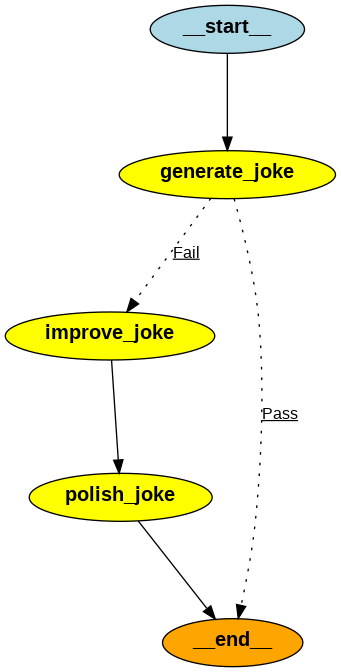

Initial joke: Why did the cat bring a ladder to the bar?  
Because it heard the drinks were on the house!


In [9]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class ChainState(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

def generate_joke(state: ChainState):
    msg = llm.invoke(f"Write a short, clean joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: ChainState):
    joke = state["joke"]
    return "Pass" if ("?" in joke or "!" in joke) else "Fail"

def improve_joke(state: ChainState):
    msg = llm.invoke(f"Make this joke funnier with subtle wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: ChainState):
    msg = llm.invoke(f"Add a surprising twist but keep it short: {state['improved_joke']}")
    return {"final_joke": msg.content}

workflow = StateGraph(ChainState)
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Pass": END, "Fail": "improve_joke"})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

chain = workflow.compile()

# Diagram
display(Image(chain.get_graph().draw_png()))

# Run
state = chain.invoke({"topic": "cats"})
print("Initial joke:", state.get("joke", ""))
if "improved_joke" in state:
    print("--- Improved:", state["improved_joke"])
if "final_joke" in state:
    print("--- Final:", state["final_joke"])

### Orchestrator-Worker pattern

A commonly used pattern in agent workflows is Orchestrator-Worker pattern, where  workers write sections with a synthesizer combines them. Below is an example implementation:

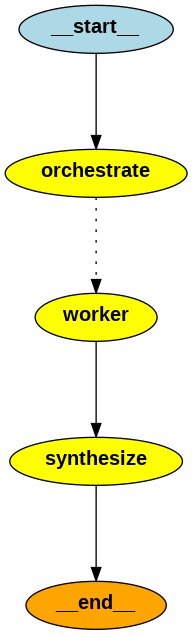

## Overview of Scaling Laws

- **Empirical relationships**  
  - **Model size (parameters)** vs. **performance**: \( \text{Perf} \propto N^{-\alpha} \) (often \( \alpha \approx 0.08\text{–}0.12\)).  
  - **Training data size** vs. **performance**: \( \text{Perf} \propto D^{-\beta} \) (typically \( \beta \approx 0.06\text{–}0.10\)).  
  - **Compute (FLOPs)** vs. **performance**: \( \text{Perf} \propto C^{-\gamma} \) (with \( \gamma \approx 0.07\text{–}0.09\)).  
  - These power‑law curves hold over several orders of magnitude for transformer‑style language models.

- **Inter‑dependencies**  
  - Increasing parameters often requires proportionally more data and compute to realize performance gains.  
  - The *effective* scaling exponent for a given resource (e.g., compute) is a weighted sum of the individual exponents, reflecting the joint optimization of size, data, and compute.

- **Theoretical basis**  
  - **Statistical learning theory**: Generalization error decreases as \( \mathcal{O}\!\left(\frac{1}{\sqrt{N}}\right) \) for i.i.d. data; empirical exponents are smaller due to over‑parameterization and implicit regularization.  
  - **Self‑supervised learning dynamics**: The loss surface becomes smoother with larger models, enabling more efficient gradient descent and yielding a power‑law decay in loss.  
  - **Information‑theoretic arguments**: Mutual information between input and output scales sub‑linearly with model capacity, leading to diminishing returns captured by the observed exponents.  
  - **Neural tangent kernel (NTK) approximations**: In the infinite‑width limit, training dynamics are linear, producing a predictable power‑law relationship between width and generalization.

- **Practical implications**  
  - Predictive scaling laws allow cost‑effective planning of model training budgets.  
  - They highlight the trade‑off between investing in larger models versus gathering more data or allocating more compute.  
  - Deviations from the power‑law often signal architectural innovations or dataset shifts.\n\n---\n\n## Key Empirical Findings

- **Loss scaling**  
  - Training loss decreases as a power law in model size \(N\):  
    \[
    \mathcal{L}(N) \approx c_{\mathcal{L}}\, N^{-\alpha}
    \]
  - Typical exponent across GPT‑style families: \(\alpha \approx 0.08\)–\(0.10\).  
  - Constant \(c_{\mathcal{L}}\) captures dataset‑specific difficulty; remains stable when moving to larger models.

- **Accuracy scaling**  
  - Downstream accuracy (e.g., GLUE, SQuAD) grows logarithmically with \(N\):  
    \[
    \text{Acc}(N) \approx c_{\text{Acc}} + \beta \log N
    \]
  - Empirical \(\beta \approx 0.02\)–\(0.04\) for language‑model families; \(c_{\text{Acc}}\) reflects baseline performance.

- **Cost scaling**  
  - Total compute cost (floating‑point operations) scales super‑linearly:  
    \[
    \text{Cost}(N) \approx c_{\text{Cost}}\, N^{\gamma}
    \]
  - Exponent \(\gamma \approx 1.5\)–\(1.7\) for transformer‑based models; \(c_{\text{Cost}}\) depends on training schedule and hardware efficiency.

- **Cross‑family constants**  
  - The constants \(c_{\mathcal{L}}, c_{\text{Acc}}, c_{\text{Cost}}\) are largely invariant across architectures (e.g., GPT‑3, PaLM, LLaMA) once the same pretraining corpus and tokenization are used.  
  - This invariance underpins the universality of the scaling laws and allows extrapolation to future, larger models.

- **Practical implications**  
  - Doubling model size yields ~\(2^{-\alpha}\) reduction in loss and ~\(\beta \log 2\) increase in accuracy, but incurs ~\(2^{\gamma}\) increase in compute.  
  - Optimal trade‑offs can be identified by balancing the diminishing returns in loss/accuracy against the steep rise in cost.\n\n---\n\n## Implications and Future Directions

- **Architecture Design**  
  - Scaling laws reveal diminishing returns for depth versus width, guiding the choice of layer counts and hidden dimensions.  
  - They motivate modular, parameter‑efficient designs (e.g., adapters, LoRA) that maintain performance while reducing effective parameter counts.  
  - Future work should quantify how architectural innovations (e.g., sparse attention, mixture‑of‑experts) shift the scaling exponents.

- **Training Budgets**  
  - Exponential growth in compute requirements is predictable; scaling laws enable cost‑effective budgeting by projecting performance gains per FLOP.  
  - They support the design of curriculum‑style training schedules that allocate compute where it yields the largest marginal benefit.  
  - Open question: How to optimally allocate heterogeneous compute resources (GPUs, TPUs, distributed clusters) under real‑world constraints.

- **Sustainability**  
  - Scaling laws expose the trade‑off between model size, data volume, and energy consumption, informing greener AI practices.  
  - They encourage research into energy‑efficient training algorithms (e.g., mixed‑precision, early‑stopping) that preserve scaling benefits.  
  - Open question: Can we derive a universal “energy‑efficiency exponent” analogous to performance exponents?

- **Open Research Questions**  
  1. **Generalization Beyond Language** – Do scaling laws hold uniformly across vision, audio, and multimodal domains?  
  2. **Data Quality vs. Quantity** – How does the scaling exponent change when training data is curated or synthetic?  
  3. **Robustness and Fairness** – What scaling behavior governs robustness to distribution shift and bias mitigation?  
  4. **Hardware‑Aware Scaling** – How do emerging architectures (e.g., neuromorphic, quantum) alter the scaling landscape?  
  5. **Theoretical Foundations** – Can we derive scaling laws from first principles of statistical learning theory or information theory?  

Addressing these questions will refine our ability to design efficient, powerful, and responsible AI systems.

In [10]:
from typing import List, Annotated
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
import operator

class Section(BaseModel):
    name: str = Field(description="Section title")
    description: str = Field(description="What to cover")

class Sections(BaseModel):
    sections: List[Section]

planner = llm.with_structured_output(Sections)

class OWState(TypedDict):
    topic: str
    sections: list[Section]
    completed: Annotated[list, operator.add]
    report: str

def orchestrate(state: OWState):
    plan = planner.invoke(f"Create 3 concise sections for a report on: {state['topic']}")
    return {"sections": plan.sections}

def worker(state: dict):
    sec: Section = state["section"]
    content = llm.invoke(
        f"Write a concise markdown section titled '{sec.name}'. Cover: {sec.description}. No intro/outro."
    ).content
    return {"completed": [content]}

def synthesize(state: OWState):
    return {"report": "\\n\\n---\\n\\n".join(state["completed"])}

from langgraph.types import Send
from langgraph.graph import StateGraph, START, END

ow = StateGraph(OWState)
ow.add_node("orchestrate", orchestrate)
ow.add_node("worker", worker)
ow.add_node("synthesize", synthesize)

def assign_workers(state: OWState):
    return [Send("worker", {"section": s}) for s in state["sections"]]

ow.add_edge(START, "orchestrate")
ow.add_conditional_edges("orchestrate", assign_workers, ["worker"])
ow.add_edge("worker", "synthesize")
ow.add_edge("synthesize", END)

ow_chain = ow.compile()
display(Image(ow_chain.get_graph().draw_png()))

state = ow_chain.invoke({"topic": "LLM scaling laws", "completed": []})
from IPython.display import Markdown
Markdown(state["report"])

Too simple? Let's do an exercise to implement a more realistic workflow:

#### Exercise: Orchestrator → Many Workers → Synthesis

### Problem setting

Build a small report generator for any topic using the **Orchestrator-Worker** pattern in LangGraph.
The **orchestrator** plans sections. Multiple **workers** run in parallel to produce:

* Section content (one worker per section)
* Key takeaways (bullets)
* A concise glossary
* A compelling title

You'll extend this with an additional worker and small quality controls.

### Your tasks

1. **Run the baseline** to see a 4-section report with bullets, glossary, and title.
2. **Add a new worker** `references_worker` that outputs 3–5 suggested references (titles only).
   * Add a `references: List[str]` field to the graph state.
   * Register the node and wire it in `assign_workers`.
   * Update `synthesizer` to include a new “Suggested References” section.
3. *(Optional)* **Scale up sections**: change the orchestrator to plan **6 sections** (not 4).
4. *(Optional)* **Length guard**: in `section_writer`, truncate any section text to **≤ 120 words**.
5. *(Optional)* De-duplicate glossary terms or bullets before synthesis.

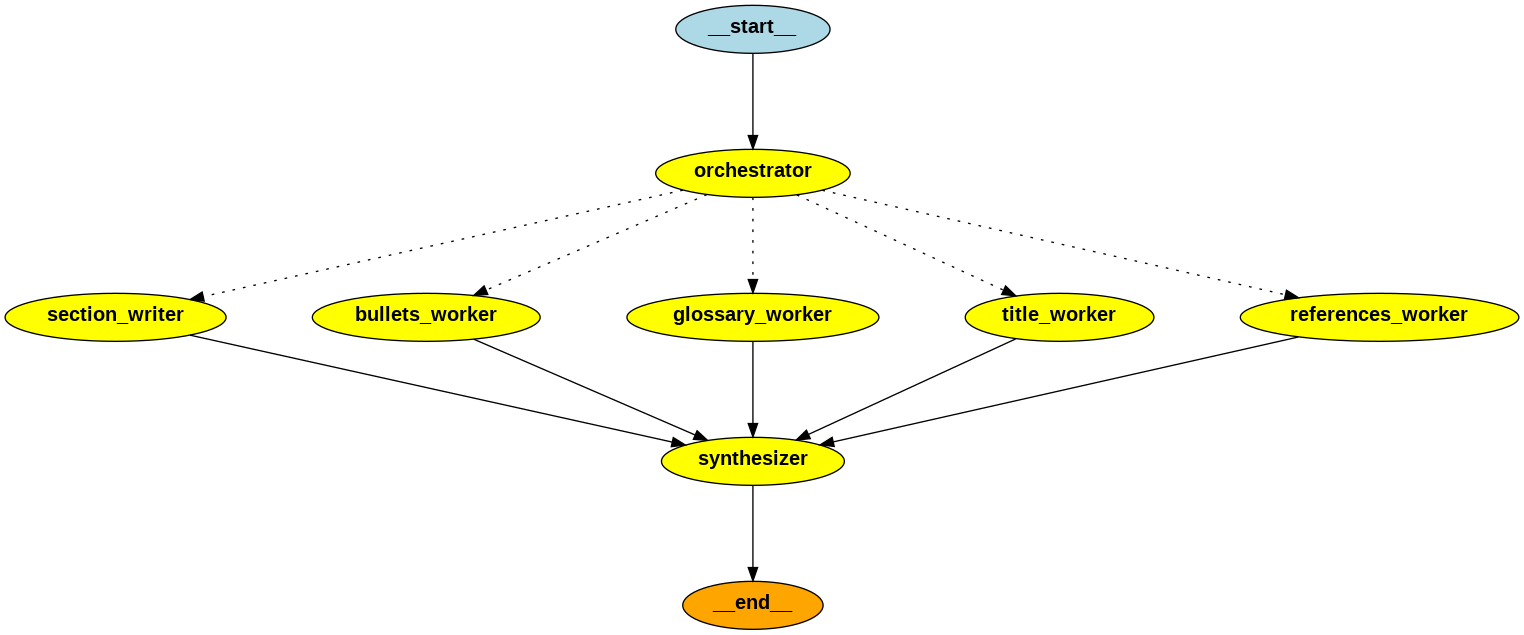

In [11]:
# Assumes `llm` is already configured with your custom OPENAI_API_KEY and base_url.

import operator
from typing import Annotated
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import Image, display, Markdown

# --------- Planning schema (orchestrator output) ----------
class Section(BaseModel):
    name: str = Field(description="Section title.")
    description: str = Field(description="What to cover.")

class SectionsPlan(BaseModel):
    sections: List[Section] = Field(description="List of report sections.")

planner = llm.with_structured_output(SectionsPlan)

# --------- Graph State ----------
class OWState(TypedDict):
    topic: str
    sections: List[Section]          # from orchestrator
    written_sections: Annotated[list, operator.add]      # each section_writer appends markdown
    bullets: List[str]               # key takeaways
    glossary: List[str]              # glossary entries
    title: str                       # report title
    #references: List[str]
    references: Annotated[list, operator.add]  # <--- UPDATE: New state field
    final_report: str

    # === TODO(1): Add new state field for references ===
def references_worker(state: OWState):
    """Worker: produce 3–5 suggested references (titles only)."""
    text = llm.invoke(
        f"Suggest 3–5 concise reference titles relevant to '{state['topic']}'."
    ).content
    # Cleaning logic to remove "1.", "-", etc.
    reference = [ln.lstrip('0123456789.- ').strip() for ln in text.splitlines() if ln.strip()]
    return {"references": reference}

# --------- Nodes ----------
def orchestrator(state: OWState):
    """Plan the report."""
    # === TODO(3): Change '4' to '6' sections after baseline ===
    plan = planner.invoke(
        f"Create 6 concise sections for a short report on: {state['topic']}. "
        f"Make sections complementary and non-overlapping."
    )
    return {"sections": plan.sections}

def section_writer(state: dict):
    """Worker: write one markdown section from a Section object."""
    sec: Section = state["section"]
    text = llm.invoke(
        f"Write a concise markdown section titled '# {sec.name}'. "
        f"Focus on: {sec.description}. Keep it under 120 words, no intro/outro outside the section."
    ).content
    words = text.split()
    if len(words)>120:
      text=" ".join(words[:120])+"..."
    # return {"written_section",[text]}

    return {"written_sections": [text]}

def bullets_worker(state: OWState):
    """Worker: produce 5 bullet key takeaways for the topic."""
    text = llm.invoke(
        f"List exactly 5 concise key takeaways about '{state['topic']}'. "
        f"Use '-' bullet markdown and keep each to one sentence."
    ).content
    lines = [ln for ln in text.splitlines() if ln.strip()]
    return {"bullets": lines}

def glossary_worker(state: OWState):
    """Worker: generate a small glossary (4–6 terms) with short definitions."""
    text = llm.invoke(
        f"Create 4–6 glossary entries (Term: Definition) for '{state['topic']}'. "
        f"Keep each definition <= 15 words."
    ).content
    entries = [ln for ln in text.splitlines() if ln.strip()]
    return {"glossary": entries}

def title_worker(state: OWState):
    """Worker: propose a compelling report title."""
    title = llm.invoke(
        f"Write a concise, informative report title (<= 10 words) for '{state['topic']}'."
    ).content.strip().strip('"')
    return {"title": title}

# === TODO(2a): Implement a references_worker that returns 3–5 reference titles ===
def references_worker(state: OWState):
    """
    Produce 3–5 suggested references (titles only) relevant to the topic.
    Return as: {"references": ["Title 1", "Title 2", ...]}
    """
    text = llm.invoke(
        f"Suggest 3–5 concise reference titles relevant to '{state['topic']}'. "
        f"Return only the titles as a simple list, one per line."
    ).content
    reference =[]
    for ln in text.splitlines():
      reference.append(ln.strip())
    return {"references":reference}


def synthesizer(state: OWState):
    """Combine all outputs into a final markdown report."""
    parts = []
    if state.get("title"):
        parts.append(f"# {state['title']}\n")
    if state.get("written_sections"):
        parts.append("\n\n".join(state["written_sections"]))
    if state.get("bullets"):
        parts.append("\n\n## Key Takeaways\n" + "\n".join(state["bullets"]))
    if state.get("glossary"):
        parts.append("\n\n## Glossary\n" + "\n".join(f"- {g}" for g in state["glossary"]))

    # === TODO(2c): Add a "Suggested References" section ===
    if  state.get("references"):
      parts.append("\n\n## references\n" + "\n".join(f"- {g}" for g in state["references"]))


    return {"final_report": "\n\n---\n\n".join(parts)}

# --------- Build Graph ----------
builder = StateGraph(OWState)
builder.add_node("orchestrator", orchestrator)
builder.add_node("section_writer", section_writer)
builder.add_node("bullets_worker", bullets_worker)
builder.add_node("glossary_worker", glossary_worker)
builder.add_node("title_worker", title_worker)
builder.add_node("synthesizer", synthesizer)

# === TODO(2b): Register your new references_worker node ===
builder.add_node("references_worker", references_worker)

def assign_workers(state: OWState):
    """
    Create parallel jobs:
      - one section_writer per planned section
      - one bullets_worker
      - one glossary_worker
      - one title_worker
      - (TODO) one references_worker
    """
    sends = [Send("section_writer", {"section": s}) for s in state["sections"]]
    sends += [Send("bullets_worker", {"topic": state['topic']})]
    sends += [Send("glossary_worker", {"topic": state['topic']})]
    sends += [Send("title_worker", {"topic": state['topic']})]

    # === TODO(2b): Wire in references_worker ===
    sends += [Send("references_worker", {"topic": state['topic']})]

    return sends

builder.add_edge(START, "orchestrator")
builder.add_conditional_edges(
    "orchestrator",
    assign_workers,
    ["section_writer", "bullets_worker", "glossary_worker", "title_worker","references_worker"]  # TODO: add "references_worker" after wiring
)

builder.add_edge("section_writer", "synthesizer")
builder.add_edge("bullets_worker", "synthesizer")
builder.add_edge("glossary_worker", "synthesizer")
builder.add_edge("title_worker", "synthesizer")
builder.add_edge("references_worker", "synthesizer")

builder.add_edge("synthesizer", END)

orchestrator_worker = builder.compile()

# Visualize
display(Image(orchestrator_worker.get_graph().draw_png()))

#### Tests for this exercise (!!! DO NOT MODIFY THESE !!!)

In [12]:
import re

def extract_sections(markdown: str):
    """
    Extract sections written by section_writer.
    Assumes the overall report title is the *first* '# ' header.
    Returns a list of section text blocks (excluding the report title).
    """
    lines = markdown.splitlines()
    # indices of all H1 headers ('# ')
    h1_idxs = [i for i, ln in enumerate(lines) if ln.startswith("# ")]
    sections = []
    if not h1_idxs:
        return sections
    # Skip the first H1 (report title)
    for idx in range(1, len(h1_idxs)):
        start = h1_idxs[idx]
        end = h1_idxs[idx + 1] if idx + 1 < len(h1_idxs) else len(lines)
        block = "\n".join(lines[start:end]).strip()
        sections.append(block)
    return sections

def word_count(text: str) -> int:
    return len(re.findall(r"\b\w+\b", text))

# ----------------- A: Basic structure checks -----------------
res = orchestrator_worker.invoke({
    "topic": "Retrieval-Augmented Generation",
    "written_sections": [],
    "bullets": [],
    "glossary": [],
    "title": "",
     "references": []  # uncomment once references_worker is implemented
})

report = res.get("final_report", "")
assert isinstance(report, str) and len(report) > 0, "final_report should be non-empty"

# Title present (first '# ' is the report title)
assert "# " in report, "Expected a top-level title ('# ...')"

# Required sections present
assert "## Key Takeaways" in report, "Missing '## Key Takeaways' section"
assert "## Glossary" in report, "Missing '## Glossary' section"

print("✅ Structure checks passed")

✅ Structure checks passed


In [13]:
res

{'topic': 'Retrieval-Augmented Generation',
 'sections': [Section(name='Introduction to Retrieval-Augmented Generation', description='Define RAG, its purpose, and its significance in modern NLP.'),
  Section(name='Core Architecture and Workflow', description='Explain the retrieval component, the generative model, and how they interact.'),
  Section(name='Key Applications and Use Cases', description='Highlight domains where RAG excels, such as question answering and knowledge-intensive tasks.'),
  Section(name='Evaluation Metrics and Benchmarks', description='Discuss how RAG performance is measured and compare to baseline models.'),
  Section(name='Challenges and Limitations', description='Address issues like retrieval quality, hallucination, and computational cost.'),
  Section(name='Future Directions and Research Opportunities', description='Outline emerging trends, potential improvements, and open research questions.')],
 'written_sections': ['# Introduction to Retrieval-Augmented Ge

## Takeaways

*   LangGraph provides a powerful way to model LLM applications as graphs of nodes and edges.
*   Agent Mode is ideal for dynamic, LLM-driven decision-making and tool use.
*   Workflow Mode is suitable for orchestrating predefined, multi-step processes.
*   The Orchestrator-Worker pattern is a common workflow design where a central orchestrator plans tasks for parallel workers, followed by a synthesis step.
*   LangGraph's state management allows information to persist and evolve throughout the graph's execution.
*   Understanding the distinction between Agent and Workflow modes is key to choosing the right approach for different LLM application needs.